In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [169]:
# Load and inspect data
data = pd.read_csv('encoded_182625_training.csv')
print(data.head())

   SeqOrder  sourceID  timediff     PTAB  BodyGroup_from  BodyGroup_to
0         0      10.0       0.0 -1182200               9             9
1         1       0.0      40.0 -1182200               9             9
2         2       4.0      45.0 -1181050               9             9
3         3       5.0      52.0 -1181050               9             9
4         4       5.0      68.0 -1181050               9             9


In [170]:
# Encoding legend
ENCODING_LEGEND = {
    0: 'Not Vital', 1: 'MRI_CCS_11', 2: 'MRI_EXU_95', 3: 'MRI_FRR_18',
    4: 'MRI_FRR_257', 5: 'MRI_FRR_264', 6: 'MRI_FRR_3', 7: 'MRI_FRR_34',
    8: 'MRI_MPT_1005', 9: 'MRI_MSR_100', 10: 'MRI_MSR_104', 11: 'MRI_MSR_21', 12: 'MRI_MSR_34'
}

In [171]:
# Prepare input (X) and output (y)
X = data[['sourceID', 'PTAB', 'BodyGroup_from', 'BodyGroup_to', 'SeqOrder']].values
y = data['timediff'].values

In [172]:
# %%
# Reshape X and y for sequential processing
sequence_length = 5  # Define how many past steps to use per prediction
X_seq, y_seq = [], []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i+sequence_length])
    y_seq.append(np.sum(y[i:i+sequence_length]))  # Ensure cumulative summation

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

print("Shape of X_seq:", X_seq.shape)
print("Shape of y_seq:", y_seq.shape)

Shape of X_seq: (3795, 5, 5)
Shape of y_seq: (3795,)


In [173]:
# Split dataset
indices = np.arange(len(X_seq))
train_indices, temp_indices = train_test_split(indices, test_size=0.4, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.625, random_state=42)

X_train, y_train = X_seq[train_indices], y_seq[train_indices]
X_val, y_val = X_seq[val_indices], y_seq[val_indices]
X_test, y_test = X_seq[test_indices], y_seq[test_indices]

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (2277, 5, 5) (2277,)
Validation set shape: (569, 5, 5) (569,)
Test set shape: (949, 5, 5) (949,)


In [174]:
# Custom loss function
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_true - y_pred))
    zero_penalty = K.sum(K.square(y_pred) * K.cast(K.equal(y_true, 0), K.floatx()))
    return mse_loss + zero_penalty

In [175]:
# LSTM Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # (sequence_length, num_features)
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss=custom_loss)

In [176]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1390377216.0000 - val_loss: 4192760.7500
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9802026.0000 - val_loss: 4130146.0000
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55500160.0000 - val_loss: 5739913.5000
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6952738.0000 - val_loss: 3760089.5000
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3355512.5000 - val_loss: 3419547.0000
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3140522.5000 - val_loss: 3571462.7500
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 206556368.0000 - val_loss: 4354510.5000
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4242538.0000 - val_loss: 4189257.0000
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3540668.5000 - val_loss: 4132511.2500
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3459257.2500 - val_loss: 3959662.2500
Epoch 11/100
72/72 ━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3277140.2500

Test Loss: 3207598.0


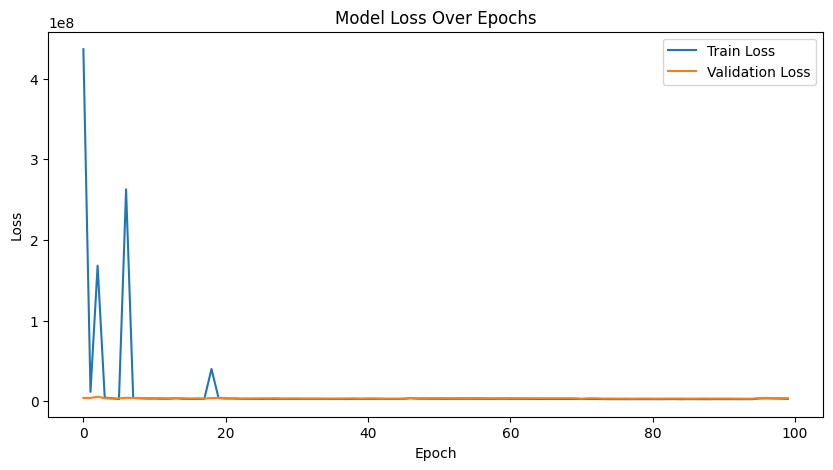

In [177]:
model.save('trained_model.h5')

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss}")

# Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [178]:
# Make predictions
predictions = model.predict(X_test).flatten()

# Post-process predictions to enforce zero constraint
predictions = np.where(y_test == 0, 0, predictions)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [179]:
# Decode sourceIDs
decoded_sourceIDs = [ENCODING_LEGEND[int(data.loc[idx, 'sourceID'])] for idx in test_indices]

# Combine predictions with sourceIDs
results_df = pd.DataFrame({
    'SourceID': decoded_sourceIDs,
    'True Timediff': y_test,
    'Predicted Timediff': predictions
})

# Print the first few rows
print(results_df.head())

# Save the results to a CSV file
output_file = 'initial_throwaway_predictions_results.csv'  # You can change the file name as needed
results_df.to_csv(output_file, index=False)

print(f"Results saved to {output_file}")

      SourceID  True Timediff  Predicted Timediff
0  MRI_MSR_104           88.0           39.400608
1  MRI_FRR_257          988.0          158.473358
2    Not Vital          237.0           39.400608
3  MRI_FRR_257         1352.0           39.400608
4  MRI_FRR_264         5235.0           39.400608
Results saved to initial_throwaway_predictions_results.csv


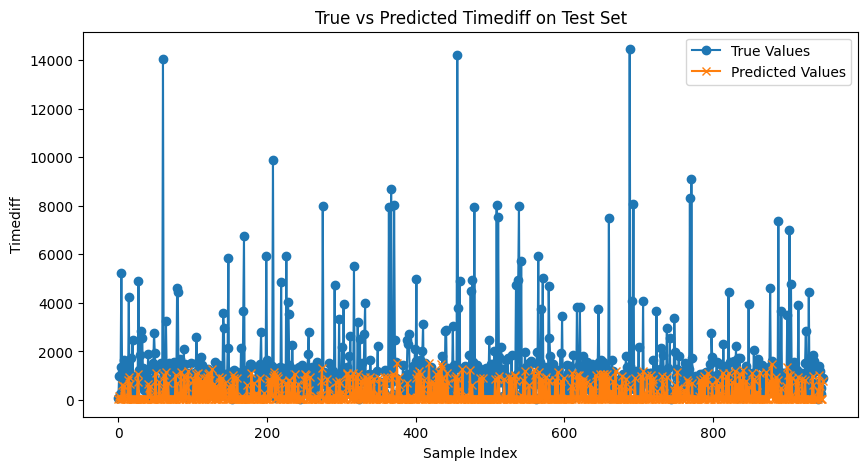

In [180]:
# %%
# Plot true vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Values', marker='o')
plt.plot(predictions, label='Predicted Values', marker='x')
plt.title('True vs Predicted Timediff on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Timediff')
plt.legend()
plt.show()

In [181]:
# %%
# Evaluate performance metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-Squared (R²): {r2}")

Mean Absolute Error (MAE): 1019.401284116337
Mean Squared Error (MSE): 3207597.8723026933
R-Squared (R²): -0.4192040595108


In [182]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

In [183]:
# Load the new dataset (only sourceID, BodyGroup_from, BodyGroup_to)
new_data = pd.read_csv('predicSourceIDandBodyGroup_182625.csv')
print("New Data Loaded:")
print(new_data.head())

New Data Loaded:
      sourceID BodyGroup_from BodyGroup_to
0  MRI_MSR_104        ABDOMEN      ABDOMEN
1   MRI_MSR_21        ABDOMEN      ABDOMEN
2  MRI_FRR_257        ABDOMEN      ABDOMEN
3  MRI_FRR_264        ABDOMEN      ABDOMEN
4    MRI_FRR_3        ABDOMEN      ABDOMEN


In [184]:
# Encoding legend
ENCODING_LEGEND = {
    'Not Vital': 0, 'MRI_CCS_11': 1, 'MRI_EXU_95': 2, 'MRI_FRR_18': 3, 'MRI_FRR_257': 4,
    'MRI_FRR_264': 5, 'MRI_FRR_3': 6, 'MRI_FRR_34': 7, 'MRI_MPT_1005': 8,
    'MRI_MSR_100': 9, 'MRI_MSR_104': 10, 'MRI_MSR_21': 11, 'MRI_MSR_34': 12
}
# BodyGroup encoding legend
BODYGROUP_ENCODING = {
    'ABDOMEN': 1, 'ARM': 2, 'HEAD': 3, 'HEART': 4, 'HIP': 5,
    'KNEE': 6, 'LEG': 7, 'PELVIS': 8, 'SHOULDER': 9, 'SPINE': 10
}


In [185]:
# Encode sourceID and BodyGroup columns using predefined legends
new_data['sourceID_encoded'] = new_data['sourceID'].map(ENCODING_LEGEND)
new_data['BodyGroup_from_encoded'] = new_data['BodyGroup_from'].map(BODYGROUP_ENCODING)
new_data['BodyGroup_to_encoded'] = new_data['BodyGroup_to'].map(BODYGROUP_ENCODING)

if 'PTAB' not in new_data.columns:
    new_data['PTAB'] = 0  # Use default 0 (or replace with training data mean)

# Ensure the order of columns matches training data
new_data = new_data[['SeqOrder', 'sourceID_encoded', 'PTAB', 'BodyGroup_from_encoded', 'BodyGroup_to_encoded']]

KeyError: "['SeqOrder'] not in index"

In [ ]:
# Reshape for LSTM model
X_new = new_data.values.reshape((new_data.shape[0], 1, new_data.shape[1]))

print("Shape of X_new:", X_new.shape)  # Should match the training input shape

# Load the trained model and make predictions
model = load_model('trained_model.h5', custom_objects={'custom_loss': custom_loss})
predictions = model.predict(X_new, batch_size=None).flatten()


# Apply cumulative sum to make timediff accumulative
new_data['Predicted_timediff'] = predictions  # Store raw predictions first
new_data['Predicted_timediff'] = predictions  # Store raw predictions first


Shape of X_new: (1156, 1, 5)
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [165]:
# Save the updated dataset
new_data.to_csv('new_data_with_predictions.csv', index=False)

In [ ]:
# Reset timediff where sourceID == 10 (MSR_104)
cumulative_timediff = []
current_sum = 0

for i in range(len(new_data)):
    if new_data.iloc[i]['sourceID_encoded'] == 10:  # Reset when sourceID is MSR_104
        current_sum = 0
        cumulative_timediff.append(0)  # Force exact 0 for sourceID 10
    else:
        current_sum += new_data.iloc[i]['Predicted_timediff']
        cumulative_timediff.append(current_sum)

# Update the dataframe
new_data['Cumulative_timediff'] = cumulative_timediff

# Save the corrected predictions
new_data.to_csv('new_data_with_reset_predictions_2.csv', index=False)
print("Updated dataset with resets saved!")


Updated dataset with resets saved!
